# Evaluation of enthalpy to temperature conversion methods

This notebook compares different methods for the conversion of enthalpy to temperature.
The evaluation is performed in terms of both computational cost and accuracy.

Three methods are considered:
- Newton's method,
- _lbh15_,
- table interpolation.

## Newton's method
Newton's method is an iterative algorithm for finding a root of a function $f(x)$, starting from an initial guess.  
The iterative formula to update the guess root is:

$$
x_{n+1} = x_{n} - \frac{f(x_{n})}{f'(x_{n})},
$$

where subsctrits $n$ and $n+1$ refer in the oreder to the old and new iterations. 

To find the temperature $T_{i+1}$ corresponding to a certain enthalpy rise $\Delta{h_{i, i+1}}$, 
given the initial temperature $T_i$, the following function is considered:

$$
f(T_{i+1}) = \Delta{h_{i, i+1}} - \Delta{h}^*(T_{i+1}),
$$

where $\Delta{h}^*(T_{i+1})$ only depends on $T_{i+1}$ and can be calculated with a correlation.

The iteration formula is then:

$$
T_{i+1, n+1} = T_{i+1, n} + \frac{\Delta{h_{i,i+1} - \Delta{h}^*(T_{i+1, n})}}{c_p(T_{i+1, n})}.
$$


## _lbh15_

_lbh15_ is a python-based library for Lead, Bismuth and LBE material properties. Given a certain temperature $T$, _lbh15_ makes use of a correlation to find the corresponding $\Delta{h}(T)$, which is computed with respect to the melting enthalpy. 

## Table interpolation

This method is based on the _NumPy_ function `interp()`. The method reads a _csv_ file that contains a set of temperatures and the corresponding enthalpies (calculated with respect to the melting enthalpy). 

The three methods described above are implemented in the file _temp_from_h.py_, and imported in the following code section. 

In [23]:
from temp_from_h import newton_method, lbh15_method, table_method
import numpy as np 
import time
import matplotlib.pyplot as plt
from collections.abc import Callable
from typing import Any
from tabulate import tabulate

# Computational time 

The average computational time is estimated for all the considered methods. 

Each method requires an array of temperatures and an array of enthalpy rises. For the scope of this analysis a fictitious temperature of 700 K and an enthalpy rise of 100 J/kg are used. 

In [10]:
temp_coolant_int = 700*np.ones(18) 
dh = 100*np.ones(18)

A function `eval_time()` is created for the avaluation of the average computational time.

In [39]:
def eval_time(method: Callable[[Any], np.ndarray]) -> None:
    """
    Function to estimate the computational time of a method
    
    Parameters
    ----------
    method : Callable[[Any], np.ndarray]
        Method for wich the computational time is evaluated
    """
    num_iterations = 1e6
    total_time = 0
    time_list = []
    average_time = [0]
    i = 0
    err = [1]
    toll = 1e-4

    while (i < num_iterations):        
        
        if method == table_method:
            data = np.genfromtxt('lead.csv', delimiter=',')
            xx = data[:,0]
            yy = data[:,1]
            
            start_time = time.time()
            T = method(dh, temp_coolant_int, xx, yy)
            end_time = time.time()
        else:
            start_time = time.time()
            T = method(dh, temp_coolant_int)
            end_time = time.time()
        
        elapsed_time = end_time - start_time
        
        total_time += elapsed_time
        time_list.append(elapsed_time)
        
        average_time.append((total_time / (i+1))) 
        if i > 1:     
            err.append(np.abs(average_time[i-1] - average_time[i]) / average_time[i-1])
        else:
            err.append(1)
            
        if i >= 300 and all(e < toll for e in err[-300:]):            
            break
        
        i += 1
    return average_time[-1] 

In [40]:
table = [["Newton", eval_time(newton_method)],
         ["lbh15", eval_time(lbh15_method)],
         ["Table", eval_time(table_method)]]

print(tabulate(table, headers=["Method", "Computational time"], tablefmt="github"))


| Method   |   Computational time |
|----------|----------------------|
| Newton   |          0.000514839 |
| lbh15    |          0.0104565   |
| Table    |          0.000102282 |


## Accuracy evaluation

A vector of $n$ temperatures `tt_ref` is created to test the accuracy of the Newton and Table interpolation methods.
For each pair of consecutive elements in `tt_ref` ($T_i$ and $T_{i+1}$), the corresponding enthalpy rise $\Delta h(T_i, T_{i+1})$ is calculated with lbh15, producing a vector of $n-1$ enthalpy values `hh_ref`.

These vectors are passed as parameters to the two methods. The results are compared with the first vector, which alse serves as a reference.

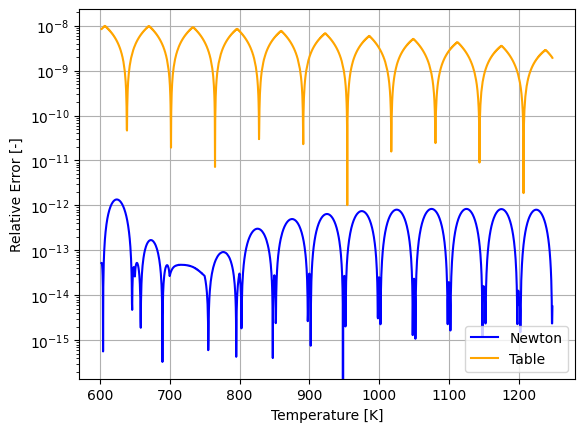

In [17]:
reference = np.genfromtxt('lead_ref.csv', delimiter=',')

tt_ref = reference[:,0]
hh_ref = reference[:,1]

dh_ref = hh_ref[1:] - hh_ref[:-1]
t0_ref = tt_ref[0]

data = np.genfromtxt('lead.csv', delimiter=',')
xx = data[:,0]
yy = data[:,1]
newton_res = newton_method(dh_ref, tt_ref[:-1])
table_res = table_method(dh_ref, tt_ref[:-1], xx, yy)

err_newton = np.abs((newton_res - tt_ref[1:]) / tt_ref[1:])
err_table = np.abs((table_res - tt_ref[1:]) / tt_ref[1:])

plt.semilogy(tt_ref[1:], err_newton, label='Newton', color='blue')
plt.semilogy(tt_ref[1:], err_table, label='Table', color='orange')


plt.xlabel('Temperature [K]')
plt.ylabel('Relative Error [-]')
plt.legend()
plt.grid()
plt.savefig('accuracy_comparison.png') 